# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [77]:
# import libraries here; add more as necessary
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# Check the structure of the data after it's loaded 
# (e.g. print the number of rows and columns, print the first few rows).

print(f'General Demographic Information: {azdias.shape[0]} Rows | {azdias.shape[1]} Columns')
print(f'Feature Summary File: {feat_info.shape[0]} Rows | {feat_info.shape[1]} Columns')

General Demographic Information: 891221 Rows | 85 Columns
Feature Summary File: 85 Rows | 4 Columns


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
pre_nan = azdias.isnull().sum()

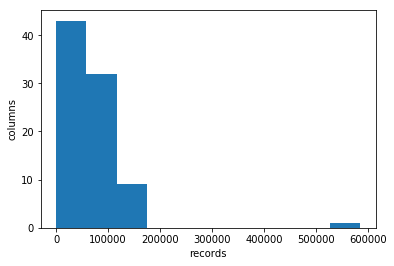

In [9]:
plt.hist(pre_nan)
plt.ylabel('columns')
plt.xlabel('records')
plt.show()

In [10]:
for index in range(feat_info.shape[0]):
    missing_unknown = feat_info.iloc[index]['missing_or_unknown']
    missing_unknown = missing_unknown.strip('[').strip(']').split(sep=',')
    missing_unknown = [int(i) if (i!='X' and i!='XX' and i!='') else i for i in missing_unknown]
    if missing_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[index]['attribute']: missing_unknown}, np.nan)

In [ ]:
def ConvertMissingValueCodesToNaNs(azdias, tab, feat_info):
    ct = 0
    for i,j in enumerate(azdias.iteritems()):
        tab = tab
        if feat_info['missing_or_unknown'][i][1:-1].split(',') != ['']:
            for item in (feat_info['missing_or_unknown'][i][1:-1].split(',')):
                if item in ['X','XX']: 
                    tab.append(item)
                    ct = ct + 1
                else: 
                    tab.append(int(item))
            azdias[j[0]] = azdias[j[0]].replace(tab, np.nan)
    return tab

In [ ]:
azdias = ConvertMissingValueCodesToNaNs(azdias, , feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
post_nan = azdias.isnull().sum()

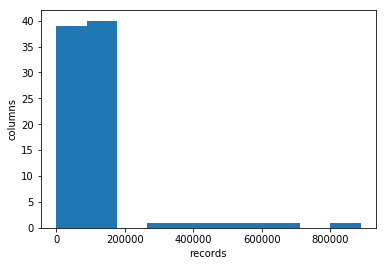

In [12]:
plt.hist(post_nan)
plt.ylabel('columns')
plt.xlabel('records')
plt.show()

In [38]:
pre = pd.Series(pre_nan, name='missing_pre')
post = pd.Series(post_nan, name='missing_post')
pre_post = pd.concat([pre, post], axis=1)
pre_post['post_percent'] = np.round(pre_post['missing_post'] / azdias.shape[0], 4)
pre_post = pre_post.sort_values('missing_post', ascending=False)
pre_post['label'] = pre_post.index

In [31]:
pre_post.groupby(['missing_post'])['label'].agg(list)

missing_post
0         [FINANZ_UNAUFFAELLIGER, FINANZTYP, FINANZ_HAUS...
2881                                 [ALTERSKATEGORIE_GROB]
4854      [GFK_URLAUBERTYP, CJT_GESAMTTYP, LP_STATUS_FEI...
18348                                  [HH_EINKOMMEN_SCORE]
73499     [WOHNDAUER_2008, SOHO_KZ, ANZ_TITEL, ANZ_PERSO...
73969                                         [KONSUMNAEHE]
77792                    [LP_FAMILIE_FEIN, LP_FAMILIE_GROB]
93148     [WOHNLAGE, OST_WEST_KZ, MIN_GEBAEUDEJAHR, GEBA...
93155                                  [GEBAEUDETYP_RASTER]
93740                      [INNENSTADT, EWDICHTE, BALLRAUM]
94572                                 [LP_LEBENSPHASE_GROB]
97008                                        [ANZ_HH_TITEL]
97274                                         [ORTSGR_KLS9]
97375                                    [ARBEIT, RELAT_AB]
97632                                 [LP_LEBENSPHASE_FEIN]
99352     [CAMEO_INTL_2015, CAMEO_DEU_2015, CAMEO_DEUG_2...
99611                      

In [41]:
# Remove the outlier columns from the dataset. 
# (You'll perform other data engineering tasks such as re-encoding and imputation later.)
pre_post = pre_post[pre_post['post_percent'] > .2]

In [43]:
azdias = azdias.drop(pre_post['label'], axis=1)

In [44]:
feat_info_clean = feat_info[feat_info['attribute'].isin(azdias.columns)]

#### Discussion 1.1.2: Assess Missing Data in Each Column

<i>Comments added below, JS</i>


The raw data was decepticely skewed and the distribution of that data would indicate that more valuable information was available than in reality. After replacing the "irrelevant" values with NA values, across each column in the dataframe, there was a clearer picture of the data's completeness. 

Even after the data was clean the data points within the FINANZ (Financial typology) and SEMIO (Personality typology) remained 100% complete, indicating that these are important and potentially valuable for use in predictions downstream. 

There were other instances of patterns among data point families, where they shared the same number of missing values after data was cleaned. 

    - CAMEO (Wealth / Life Stage Typology): 99352 missing values across all the underlying data points
    - PLZ8 (Macro Cell Features: Housing/Building): 116515 missing values across all the underlying data points
    - KBA05 (Micro Cell Features: Housing/Building): 1333324 missing values across all the underlying data points

Six columns ('TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH') were dropped in this step as they were missing more than twenty percent of their values with one column ('TITEL_KZ') ranging as high as 99.8%.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

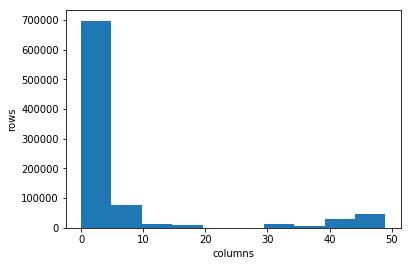

In [45]:
# How much data is missing in each row of the dataset?
row_pre_nan = azdias.isnull().sum(axis=1)

# Ensure that data is coming through as expected
plt.hist(row_pre_nan)
plt.ylabel('rows')
plt.xlabel('columns')
plt.show()

Based on the distribution of missing values per row, it appears that there are two groupings split by a range of 20- to 30 missing values, so I will take the bottom of this and use 20 missing rows as the cut-off.

In [49]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

azdias_less = azdias[row_pre_nan <= 20]
azdias_more = azdias[row_pre_nan > 20]

In [50]:
# Compare the distribution of values for at least five columns where there are no or few missing values, 
# between the two subsets.

def comparison(col):
    
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Missing less than 5')
    
    sns.countplot(azdias.loc[azdias_less.index, col])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Missing more than 5')
    
    sns.countplot(azdias.loc[azdias_more.index, col]);

    fig.suptitle(col)
    plt.show()

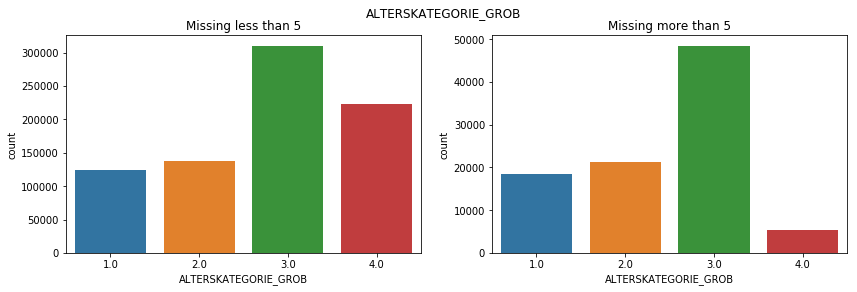

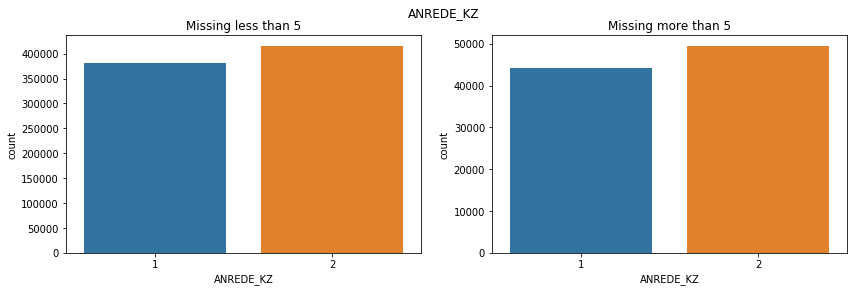

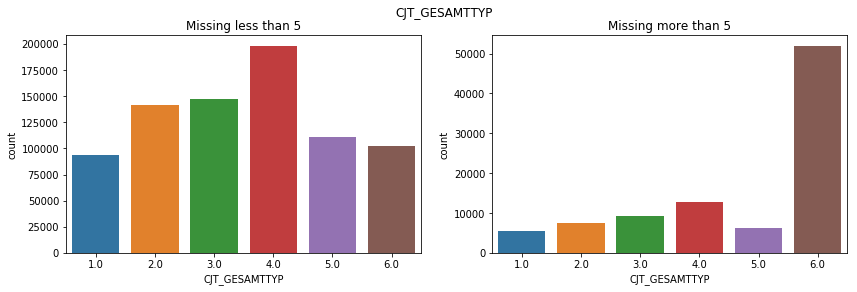

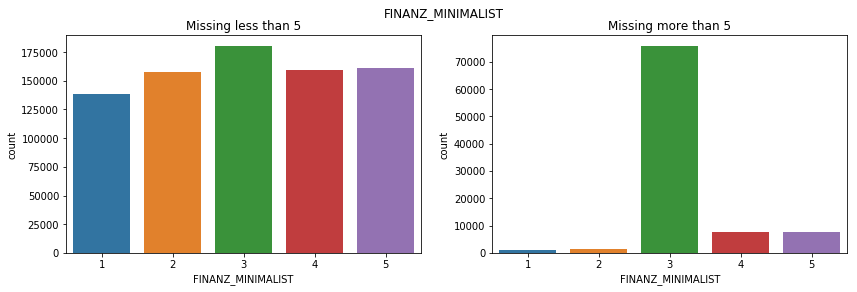

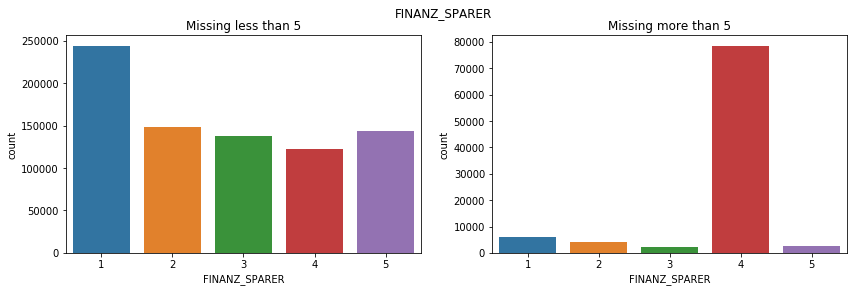

In [51]:
for col in azdias.columns[0:5]:
    comparison(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

<i>Comments added below, JS</i>

While the distributions vary for each row and column combination, the completeness and quality of the rows in the data set only considering rows with less than 20 null values is better for purposes of clustering, in that it is more evenly distributed. 

It would seem based on the charts above that the rows which are missing more than 20 values are heavily weighted towards one specific value creating a false bias within that feature. An exception from the sample above would be the feature ANDREDE_KZ (Gender) which would appear to be well populated regardless of other features in the row.

Based on this analysis it would appear that using this paired down data set would provide more optimal results than using the complete, raw set.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [52]:
# How many features are there of each data type?
feat_info.groupby('type')['type'].agg('count')

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [53]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

categorical = feat_info_clean[feat_info_clean["type"] == "categorical"]
binary = [i for i in categorical["attribute"] if azdias_less[i].unique().shape[0] == 2]
multi_level = [i for i in categorical["attribute"] if azdias_less[i].unique().shape[0] > 2]

In [54]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [55]:
multi_level

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [56]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_less = azdias_less.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}})

#### Discussion 1.2.1: Re-Encode Categorical Features

<i>Comments added below, JS</i>

After identifying which of the categorical attributes were binary and which were multi-level, I re-encoded the one binary attribute that was lacking a numerical value. After that step was completed, I attempted to one hot encode the mulit-level/categorical values however after several iterations the results were optimized by dropping these features. Lastly I updated the dataframe of values in which rows are missing less than 5 values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
ignore = [-1, 0]
azdias_less['PRAEGENDE_JUGENDJAHRE'] = azdias_less['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in ignore else x)

In [58]:
mainstream = [1, 3, 5, 8, 10, 12, 14]
decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
azdias_less['DECADE'] = azdias_less['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decades.get(x))
azdias_less['MOVEMENT'] = azdias_less['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in mainstream else 1)

In [59]:
azdias_less['CAMEO_INTL_2015'] = azdias_less['CAMEO_INTL_2015'].replace(np.nan, 0)

In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_less['WEALTH'] = azdias_less['CAMEO_INTL_2015'].astype(str).apply(lambda x: x[0] if x else x)
azdias_less['WEALTH'] = azdias_less['WEALTH'].replace('', 0).astype(int)

In [61]:
azdias_less['LIFESTAGE'] = azdias_less['CAMEO_INTL_2015'].astype(str).apply(lambda x: x[-1] if x else x)
azdias_less['LIFESTAGE'] = azdias_less['LIFESTAGE'].replace('', 0).astype(int)

#### Discussion 1.2.2: Engineer Mixed-Type Features

<i>Comments added below, JS</i>


For the attribute PRAEGENDE_JUGENDJAHRE I started by encoding the irrelevant values (-1, 0) as nan values. I then created new attributes for DECADE (binary) and MOVEMENT (categorical) by mapping the values to a list of values (former) and hot encoding the values (latter) using the information foudn in the data dictionary.

For the attribute CAMEO_INTL_2015 I removed the nan values, converted the data type of the values to string from float, split them by position and returned them back to integer.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [62]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.

drop_columns = feat_info_clean[feat_info_clean["type"].isin(["categorical", "mixed"])].attribute
azdias_less = azdias_less.drop(list(drop_columns), axis=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [112]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: 
        Demographics DataFrame
    OUTPUT: 
        Trimmed and cleaned demographics DataFrame
    """
    
    ignore = [-1, 0]
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    decades = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}

    pre = df.isnull().sum()

    for index in range(feat_info.shape[0]):
        missing_unknown = feat_info.iloc[index]['missing_or_unknown']
        missing_unknown = missing_unknown.strip('[').strip(']').split(sep=',')
        missing_unknown = [int(i) if (i != 'X' and i != 'XX' and i != '') else i for i in missing_unknown]

        if missing_unknown != ['']:
            df = df.replace({feat_info.iloc[index]['attribute']: missing_unknown}, np.nan)

    post_nan = df.isnull().sum()
    post = pd.Series(post_nan, name='missing_post')

    pre_post = pd.concat([pre, post], axis=1)
    pre_post['post_percent'] = np.round(pre_post['missing_post'] / df.shape[0], 4)
    pre_post = pre_post[pre_post['post_percent'] > .3]
    df = df.drop(pre_post.index, axis=1)
    
    
    df = df[df.isnull().sum(axis=1) <= 20]
    feat_info = feat_info[feat_info['attribute'].isin(df.columns)]
    
    df = df.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}})

    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in ignore else x)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace(np.nan, 0)

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decades.get(x, ''))
    df['DECADE'] = df['DECADE'].replace('', 0).astype(int)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in mainstream else 1).astype(int)

    df['WEALTH'] = df['CAMEO_INTL_2015'].astype(str).apply(lambda x: x[0] if x else x)
    df['WEALTH'] = df['WEALTH'].replace('', 0).astype(int)
    
    df['LIFESTAGE'] = df['CAMEO_INTL_2015'].astype(str).apply(lambda x: x[-1] if x else x)
    df['LIFESTAGE'] = df['LIFESTAGE'].replace('', 0).astype(int)
    
    categorical = feat_info[feat_info["type"] == "categorical"]
    binary = [i for i in categorical["attribute"] if df[i].unique().shape[0] == 2]
    drop_columns = feat_info[feat_info["type"].isin(["categorical", "mixed"])].attribute

    df = df.drop(list(drop_columns), axis=1)
                             
    return df

*All changes and functions made to preprocessing above have been made in the clean_data function as well.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [64]:
az = azdias_less.copy()

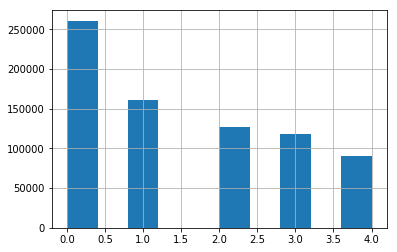

In [74]:
az['KBA05_ANTG1'].hist()

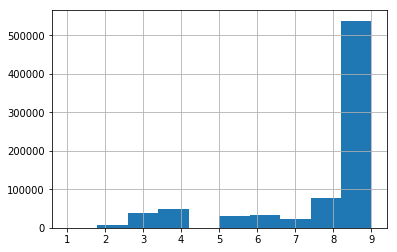

In [76]:
az['WOHNDAUER_2008'].hist()

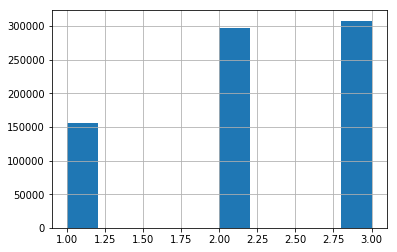

In [84]:
az['HEALTH_TYP'].hist()

In [65]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
# Apply feature scaling to the general population demographics data.
imputer = Imputer(strategy='most_frequent')
imputed_features = imputer.fit_transform(az)

In [78]:
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)

### Discussion 2.1: Apply Feature Scaling

<i>Comments added below, JS</i>

I opted to ensure that there were no missing values using the Imputer class populating with most frequent value as mean and median are less effect on binary data. Initially I opted to use Standard Scaler but after sampling the distributions of various columns (some listed above) I switch strategies to using a MinMaxScaler. It would appear that there is enough data that is non-Gaussian, that it makes sense to use the MinMaxScaler so as to maintain the shape of the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [79]:
def scree_plot(pca):

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

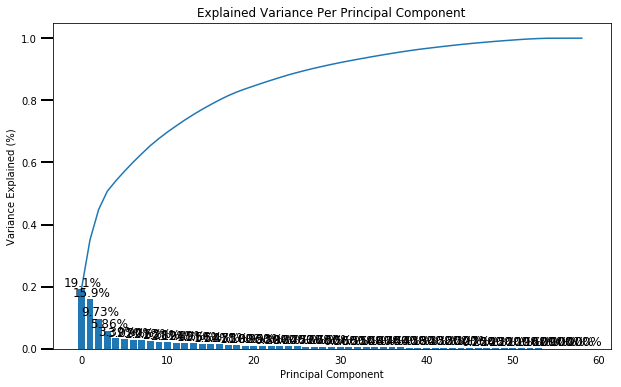

In [80]:
# Apply PCA to the data.
pca_raw = PCA()
pca_features = pca_raw.fit(standardized_features)
scree_plot(pca_raw)

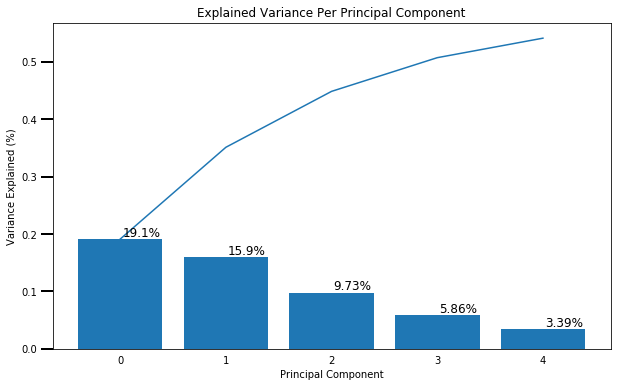

In [81]:
# Exploring PCA variance explainiation distributions
pca_5 = PCA(n_components=5)
pca_5_features = pca_5.fit_transform(standardized_features)
scree_plot(pca_5)

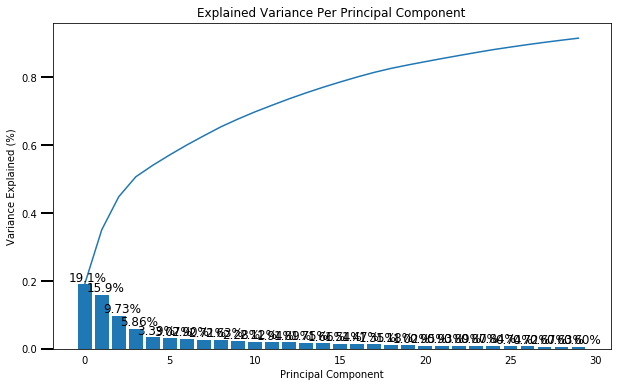

In [85]:

pca = PCA(n_components=30)
pca_features = pca.fit_transform(standardized_features)
scree_plot(pca)

In [86]:
print(f"PCA Model accounts for {pca.explained_variance_ratio_.sum()} of variance in data")

PCA Model accounts for 0.9155978344745345 of variance in data


### Discussion 2.2: Perform Dimensionality Reduction

<i>Comments added below, JS</i>

After doing a variety of analysis (some of which is captured above) I choose to use 30 components for the next step. While a high number it accounts for 91% of the variance, and elimiates just over 50% of overall features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [88]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def interpret_pca(n, pca):
    
    components = pd.DataFrame(pca.components_, columns=list(az.columns))
    weights = components.iloc[n].sort_values(ascending=False)
    
    return weights

In [89]:
interpret_pca(0, pca)

FINANZ_SPARER            0.276210
SEMIO_REL                0.196225
SEMIO_PFLICHT            0.190728
PLZ8_ANTG4               0.189994
FINANZ_UNAUFFAELLIGER    0.183648
DECADE                   0.181936
FINANZ_ANLEGER           0.181354
PLZ8_ANTG3               0.176201
HH_EINKOMMEN_SCORE       0.161698
SEMIO_TRADV              0.158461
EWDICHTE                 0.157670
WEALTH                   0.147200
SEMIO_RAT                0.139944
SEMIO_KULT               0.139465
ORTSGR_KLS9              0.132987
SEMIO_MAT                0.128614
SEMIO_FAM                0.127659
FINANZ_HAUSBAUER         0.119625
KBA05_ANTG3              0.119120
KBA05_ANTG4              0.111710
RELAT_AB                 0.105978
PLZ8_ANTG2               0.082130
ARBEIT                   0.080895
HEALTH_TYP               0.073882
SEMIO_SOZ                0.065997
REGIOTYP                 0.049730
KKK                      0.037642
PLZ8_HHZ                 0.028196
ONLINE_AFFINITAET        0.025362
KBA05_ANTG2   

In [90]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(1, pca)

PLZ8_ANTG4               0.217546
EWDICHTE                 0.200492
PLZ8_ANTG3               0.200262
FINANZ_HAUSBAUER         0.200109
ALTERSKATEGORIE_GROB     0.193205
FINANZ_VORSORGER         0.182473
RETOURTYP_BK_S           0.172758
ORTSGR_KLS9              0.165026
WEALTH                   0.153128
SEMIO_ERL                0.150283
SEMIO_LUST               0.147889
W_KEIT_KIND_HH           0.140720
HH_EINKOMMEN_SCORE       0.138984
KBA05_ANTG4              0.135366
RELAT_AB                 0.134761
KBA05_ANTG3              0.119865
ARBEIT                   0.100727
SEMIO_KAEM               0.095869
PLZ8_ANTG2               0.094521
SEMIO_KRIT               0.078420
SEMIO_DOM                0.051389
REGIOTYP                 0.035755
PLZ8_HHZ                 0.030662
WOHNDAUER_2008           0.021103
KKK                      0.015318
ANZ_HAUSHALTE_AKTIV      0.009323
KBA05_ANTG2              0.005640
ANZ_HH_TITEL             0.001597
ANZ_TITEL                0.000196
ANZ_PERSONEN  

In [91]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(2, pca)

SEMIO_VERT               0.382373
SEMIO_SOZ                0.305977
SEMIO_FAM                0.302464
SEMIO_KULT               0.296986
FINANZ_MINIMALIST        0.166162
SEMIO_REL                0.125808
RETOURTYP_BK_S           0.114427
SEMIO_MAT                0.100716
W_KEIT_KIND_HH           0.089269
FINANZ_VORSORGER         0.082085
EWDICHTE                 0.056624
MOVEMENT                 0.056011
PLZ8_ANTG4               0.054423
PLZ8_ANTG3               0.048118
ORTSGR_KLS9              0.046467
SEMIO_LUST               0.040986
RELAT_AB                 0.034404
ALTERSKATEGORIE_GROB     0.033776
ARBEIT                   0.025466
KBA05_ANTG4              0.024904
PLZ8_ANTG2               0.022571
WEALTH                   0.022052
WOHNDAUER_2008           0.017681
KBA05_ANTG3              0.008893
PLZ8_HHZ                 0.007664
ANZ_HAUSHALTE_AKTIV      0.001623
ANZ_TITEL                0.000409
ANZ_HH_TITEL             0.000368
ANZ_PERSONEN            -0.000458
MIN_GEBAEUDEJA

### Discussion 2.3: Interpret Principal Components

<h3>PC1</h3>

Top Features: 

    - FINANZ_SPARER (Financial Typology): 
        The median value (3) indicates an average inclination towards being a money saver
    - SEMIO_REL (Personality Typology): 
        The median value (4) indicates an average affinity for being religious
        
Bottom Features:

    - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis): 
        The median value (3) indicates an average age of 46 - 60 years old
    - FINANZ_MINIMALIST (Financial Typology): 
        The median value (3) indicates average allocation of low financial interest
        

<h3>PC2</h3>

Top Features: 

    - PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region): 
       The median value (1) indicates a lower number of 10+ family houses
    - EWDICHTE (Density of households per square kilometer)
       The median value (4) indicates 150 - 319 households per km^2
       
Bottom Features:

    - FINANZ_UNAUFFAELLIGER (Financial Typology): 
        The median value (2) indicates a high number of people are financially inconspicuous
    - FINANZ_ANLEGER (Financial Typology)
        The median value (3) indicates people are average investors
   
   
<h3>PC3</h3>

Top Features: 

    - SEMIO_VERT (Personality typology, for each dimension: dreamful)
        The median value (5) indicates low affinity for being dreamful
    - SEMIO_SOZ (Personality typology, for each dimension)
        The median value (4) indicates average affinity for being socially-minded
    
Bottom Features:

    - SEMIO_DOM (Personality typology, for each dimension)
        The median value (5) indicates low affinity being dominant-minded
    - SEMIO_KAEM (Personality typology, for each dimension)
        The median value (4) indicates average affinity for having a combative attitude


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Calculating K Means with 1 clusters
Calculating K Means with 2 clusters
Calculating K Means with 3 clusters
Calculating K Means with 4 clusters
Calculating K Means with 5 clusters
Calculating K Means with 6 clusters
Calculating K Means with 7 clusters
Calculating K Means with 8 clusters
Calculating K Means with 9 clusters
Calculating K Means with 10 clusters
Calculating K Means with 11 clusters
Calculating K Means with 12 clusters
Calculating K Means with 13 clusters
Calculating K Means with 14 clusters
Calculating K Means with 15 clusters
Calculating K Means with 16 clusters
Calculating K Means with 17 clusters
Calculating K Means with 18 clusters
Calculating K Means with 19 clusters


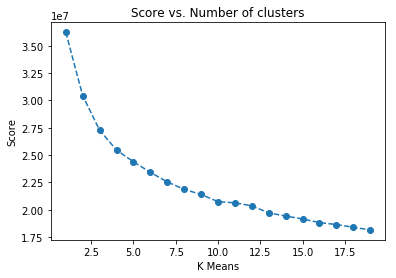

In [283]:
# Over a number of different cluster counts run k-means clustering on the data and compute the average 
# within-cluster distances.
scores = []
iterations = list(range(1,20))

for i in kmeans:
    print(f"Calculating K Means with {i} clusters")
    model = KMeans(n_clusters=i).fit(pca_features)
    scores.append(np.abs(model.score(pca_features)))
    
plt.plot(iterations, scores, linestyle='--', marker='o');
plt.xlabel('K Means');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');

In [105]:
kmeans_model = KMeans(n_clusters=13).fit(pca_features)
kmeans_final = np.abs(kmeans_model.score(pca_features))

In [106]:
azdias_kmeans = kmeans_model.predict(pca_features)

### Discussion 3.1: Apply Clustering to General Population

While the kmeans distribution is more slope like, there is a slight increase at 12 clusters followed by a decrease at 13, so I will proceed with 13 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [113]:
# Load in the customer demographics data.
customers_raw = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',  sep=';')

In [114]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers_raw, feat_info)

In [115]:
set(az.columns) - set(customers.columns)

{'KKK', 'REGIOTYP'}

In [116]:
# Prepping customers dataframe with missing columns so that Imputer, Scaler, PCA and KMeans can be applied
customers.insert(loc=57, column='KKK', value=0)
customers.insert(loc=58, column='REGIOTYP', value=0)

In [117]:
customers_imputer = imputer.transform(customers)
customers_scaler = scaler.transform(customers_imputer)
customers_pca = pca.transform(customers_scaler)

In [118]:
customers_kmeans = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [147]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_cluster = []
customer_cluster = []

x = [i+1 for i in range(13)]
for i in range(13):
    general_cluster.append((azdias_kmeans == i).sum()/len(azdias_kmeans))
    customer_cluster.append((customers_kmeans == i).sum()/len(customers_kmeans))

clusters = pd.DataFrame({'cluster' : x, 'general' : general_cluster, 'customers': customer_cluster })
clusters['difference'] = clusters.apply(lambda x: x['general'] - x['customers'], axis=1)
clusters.sort_values('difference')


,cluster,general,customers,difference
4,5,0.075000,0.939762,-0.864762
6,7,0.027502,0.000184,0.027319
12,13,0.062471,0.009311,0.053160
7,8,0.073478,0.013307,0.060171
1,2,0.063266,0.000466,0.062800
3,4,0.074759,0.011020,0.063740
8,9,0.090851,0.024694,0.066157
11,12,0.069956,0.000042,0.069914
9,10,0.070720,0.000078,0.070642
10,11,0.080996,0.000007,0.080989


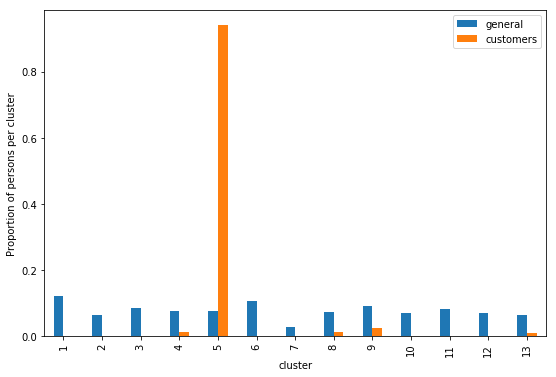

In [148]:
clusters.plot(x='cluster', y = ['general', 'customers'], kind='bar', figsize=(9,6))
plt.ylabel('Proportion of persons per cluster')
plt.show()

In [149]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

clusters = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_))

In [150]:
cluster1 = pd.Series(clusters[0], index=customers.columns)
cluster1

ALTERSKATEGORIE_GROB        3.332078
FINANZ_MINIMALIST           3.315033
FINANZ_SPARER               1.923123
FINANZ_VORSORGER            4.230980
FINANZ_ANLEGER              1.568701
FINANZ_UNAUFFAELLIGER       1.662461
FINANZ_HAUSBAUER            3.642055
HEALTH_TYP                  2.410945
RETOURTYP_BK_S              4.493595
SEMIO_SOZ                   4.866273
SEMIO_FAM                   5.246296
SEMIO_REL                   3.874520
SEMIO_MAT                   4.212531
SEMIO_VERT                  5.751979
SEMIO_LUST                  5.019760
SEMIO_ERL                   4.289616
SEMIO_KULT                  5.026926
SEMIO_RAT                   2.699017
SEMIO_KRIT                  3.808847
SEMIO_DOM                   3.381674
SEMIO_KAEM                  3.042773
SEMIO_PFLICHT               3.376615
SEMIO_TRADV                 2.881462
ANZ_PERSONEN                1.385039
ANZ_TITEL                   0.004490
HH_EINKOMMEN_SCORE          5.370127
W_KEIT_KIND_HH              5.034307
W

In [141]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster4 = pd.Series(clusters[3], index=customers.columns)
cluster4

ALTERSKATEGORIE_GROB        3.376504
FINANZ_MINIMALIST           4.831374
FINANZ_SPARER               1.558437
FINANZ_VORSORGER            4.281538
FINANZ_ANLEGER              1.443854
FINANZ_UNAUFFAELLIGER       2.104119
FINANZ_HAUSBAUER            1.980414
HEALTH_TYP                  2.020923
RETOURTYP_BK_S              4.054182
SEMIO_SOZ                   4.829332
SEMIO_FAM                   4.886795
SEMIO_REL                   3.786214
SEMIO_MAT                   3.949327
SEMIO_VERT                  6.231972
SEMIO_LUST                  5.270054
SEMIO_ERL                   4.202332
SEMIO_KULT                  4.842002
SEMIO_RAT                   2.700875
SEMIO_KRIT                  3.077329
SEMIO_DOM                   3.331576
SEMIO_KAEM                  2.704968
SEMIO_PFLICHT               3.218122
SEMIO_TRADV                 3.100363
ANZ_PERSONEN                2.206860
ANZ_TITEL                   0.012864
HH_EINKOMMEN_SCORE          2.471795
W_KEIT_KIND_HH              4.266772
W

In [142]:
cluster8 = pd.Series(clusters[7], index=customers.columns)
cluster8

ALTERSKATEGORIE_GROB        3.061708
FINANZ_MINIMALIST           3.446416
FINANZ_SPARER               3.095907
FINANZ_VORSORGER            2.988009
FINANZ_ANLEGER              3.974639
FINANZ_UNAUFFAELLIGER       2.949853
FINANZ_HAUSBAUER            1.864532
HEALTH_TYP                  2.525806
RETOURTYP_BK_S              2.812362
SEMIO_SOZ                   3.029848
SEMIO_FAM                   2.655201
SEMIO_REL                   2.822109
SEMIO_MAT                   2.713142
SEMIO_VERT                  3.408771
SEMIO_LUST                  3.920434
SEMIO_ERL                   5.615786
SEMIO_KULT                  2.881297
SEMIO_RAT                   3.629246
SEMIO_KRIT                  5.217742
SEMIO_DOM                   5.250998
SEMIO_KAEM                  4.965455
SEMIO_PFLICHT               3.559626
SEMIO_TRADV                 2.900767
ANZ_PERSONEN                2.210034
ANZ_TITEL                   0.000936
HH_EINKOMMEN_SCORE          3.752982
W_KEIT_KIND_HH              2.965783
W

In [143]:
cluster9 = pd.Series(clusters[8], index=customers.columns)
cluster9

ALTERSKATEGORIE_GROB        1.654672
FINANZ_MINIMALIST           2.371870
FINANZ_SPARER               3.936825
FINANZ_VORSORGER            2.177100
FINANZ_ANLEGER              4.305053
FINANZ_UNAUFFAELLIGER       3.985035
FINANZ_HAUSBAUER            2.825245
HEALTH_TYP                  2.277101
RETOURTYP_BK_S              2.449884
SEMIO_SOZ                   2.624106
SEMIO_FAM                   3.875276
SEMIO_REL                   5.376668
SEMIO_MAT                   5.158268
SEMIO_VERT                  2.615589
SEMIO_LUST                  2.965253
SEMIO_ERL                   4.256071
SEMIO_KULT                  4.180643
SEMIO_RAT                   6.321188
SEMIO_KRIT                  5.447151
SEMIO_DOM                   6.010393
SEMIO_KAEM                  5.592082
SEMIO_PFLICHT               6.133797
SEMIO_TRADV                 6.025098
ANZ_PERSONEN                1.967905
ANZ_TITEL                   0.002208
HH_EINKOMMEN_SCORE          3.938403
W_KEIT_KIND_HH              3.325429
W

In [144]:
cluster13 = pd.Series(clusters[12], index=customers.columns)
cluster13

ALTERSKATEGORIE_GROB        3.477553
FINANZ_MINIMALIST           4.223601
FINANZ_SPARER               1.478693
FINANZ_VORSORGER            4.379455
FINANZ_ANLEGER              1.939745
FINANZ_UNAUFFAELLIGER       2.045765
FINANZ_HAUSBAUER            2.442601
HEALTH_TYP                  2.108388
RETOURTYP_BK_S              3.684825
SEMIO_SOZ                   3.182185
SEMIO_FAM                   2.079207
SEMIO_REL                   2.180522
SEMIO_MAT                   2.445626
SEMIO_VERT                  3.117618
SEMIO_LUST                  5.273493
SEMIO_ERL                   6.309640
SEMIO_KULT                  1.959397
SEMIO_RAT                   3.542227
SEMIO_KRIT                  5.858255
SEMIO_DOM                   6.111881
SEMIO_KAEM                  5.851268
SEMIO_PFLICHT               3.108230
SEMIO_TRADV                 2.816407
ANZ_PERSONEN                2.112811
ANZ_TITEL                   0.012122
HH_EINKOMMEN_SCORE          2.449081
W_KEIT_KIND_HH              4.133689
W

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the data above cluster 5 is over-represented in the customer dataset, weighted by customer age and financial interest.

Based on the data aboove most clusters are underrepresented in the customer data, however, clusters 4, 8, 9 and 13 are underrepresented for the data assigned to them relative to the overall distribution. 

Lastly, based on the data above the general customers appear to be distributed relatively evenly across the clusters with slightly lower weights in 2, 10, and 13 with a more significant dip at cluster 7.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.